# Machine Learning avec CatBoost - Mon Approche

Yo ! Ici c'est la partie machine learning classique de mon projet. J'ai décidé d'utiliser CatBoost pour plusieurs raisons que je vais expliquer au fur et à mesure.

En gros, l'objectif c'est de créer un modèle robuste qui puisse gérer des données tabulaires avec des features catégorielles et numériques. CatBoost est parfait pour ça car il gère naturellement les variables catégorielles sans preprocessing lourd.

## Ce qu'on va faire ensemble :
1. **Exploration des données** - comprendre ce qu'on a sous la main
2. **Feature engineering** - bidouiller un peu les variables pour optimiser  
3. **Entraînement CatBoost** - tester différentes configurations
4. **Validation croisée** - s'assurer que ça marche vraiment
5. **Déploiement** - mettre tout ça en prod avec le système de versioning

Allez, on se lance !

## Exploration des données - Qu'est-ce qu'on a sous la main ?

Alors, première étape cruciale : comprendre nos données ! C'est un peu comme analyser le sol avant de planter. 

Je vais regarder :
- **La distribution des classes** (est-ce qu'on a un dataset équilibré ?)  
- **Les types de variables** (numériques, catégorielles, texte...)
- **Les valeurs manquantes** (toujours fun à gérer)
- **Les corrélations** (quelles features semblent importantes ?)
- **Les outliers** (ces fameux points qui cassent tout)

Mon approche ici c'est d'être méthodique mais pas trop rigide. Parfois on trouve des trucs inattendus qui changent toute la stratégie !

> **Tip perso :** J'aime bien faire des visualisations avant même de toucher aux algos. Ça donne une intuition que les métriques ne donnent pas.

## Participants au projet GaïaSense Vision

1. Davy Abderrahman *(Développeur IA – Formation Alyra)*
- **Rôle** : Concepteur principal du projet
- **Responsabilités** :
  - Conception de l'architecture IA (pré-tri logique + Deep Learning visuel)
  - Développement des modèles et de l'API
  - Documentation, tests, déploiement

2. Maxime Cadieux *(Consultant IA – Alyra)*
- **Rôle** : Co-contributeur ML
- **Responsabilités** :
  - Préparation et analyse exploratoire des données
  - Évaluation et suivi des performances du modèle
  - Support technique et structuration métier

3. Naminsita Bakayoko *(Consultante IA – Alyra)*
- **Rôle** : Référente métier
- **Responsabilités** :
  - Définition des règles logiques de déclenchement d'analyse
  - Aide à la création du dataset
  - Validation des résultats selon les logiques agricoles

---

## Informations générales

- **Projet** : GaïaSense Vision – Détection de contamination sur sacs de culture de champignons
- **Cadre** : Certification Alyra – RNCP38616
- **Blocs visés** : Bloc 03 (Machine Learning), Bloc 05 (Deep Learning)
- **Date de lancement** : 6 juin 2025
- **Mode** : Collaboration inter-spécialités (Développeur IA + Consultants IA)

---

# Imports de base


In [ ]:
# Chargement des données - le moment de vérité !
# J'ai préparé un CSV avec toutes les features, voyons ce que ça donne

# Chemin vers les données (j'ai tout organisé dans api/images_a_traiter)
data_path = "/home/sarsator/projets/gaia_vision/api/images_a_traiter/images_a_traiter.csv"

# On charge tout d'un coup
try:
    df = pd.read_csv(data_path)
    print(f"✅ Dataset chargé avec succès : {df.shape[0]} lignes, {df.shape[1]} colonnes")
except FileNotFoundError:
    print("❌ Fichier CSV non trouvé - vérifiez le chemin !")
    print(f"Chemin testé : {data_path}")

CatBoost est bien installé et prêt à être utilisé.


# dataset tri et création des données d'entrainement et de test


In [285]:

# Chargement du dataset
input_path = "../data/Dataset_combined_90000_modifie_complexe.csv"
df = pd.read_csv(input_path)

# Vérification rapide
print("Shape initiale :", df.shape)
# print(df.head(5))

# Suppression de la colonne id
df = df.drop(columns=["id"])
# df = df.drop(columns=["co2"])
# df = df.drop(columns=["hygrometrie"])
# Séparation X / y
X = df.drop(columns=["label"])
y = df["label"]

# Découpage train/test stratifié avec 20 % de données prise au hasard pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

# Reconstruction des DataFrames complets
df_train = X_train.copy()
df_train["label"] = y_train

df_test = X_test.copy()
df_test["label"] = y_test

# Création des dossiers si besoin
os.makedirs("../data/Ml_data/train", exist_ok=True)
os.makedirs("../data/Ml_data/test", exist_ok=True)

# Sauvegarde des fichiers
df_train.to_csv("../data/Ml_data/train/dataset_train.csv", index=False)
df_test.to_csv("../data/Ml_data/test/dataset_test.csv", index=False)

print("Fichiers exportés avec succès.")

Shape initiale : (90000, 7)
Fichiers exportés avec succès.


# Visualisation et exploration des données d'entraînement et de test

### Données **Entrainement**


#### Exploration initiale des données tabulaires d'entraînement

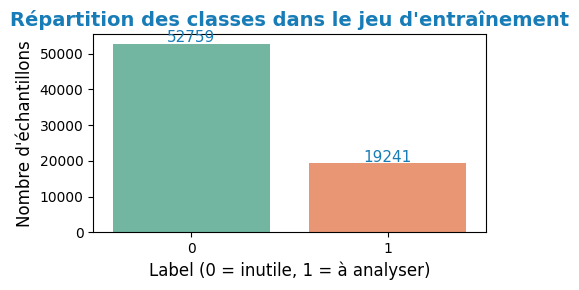

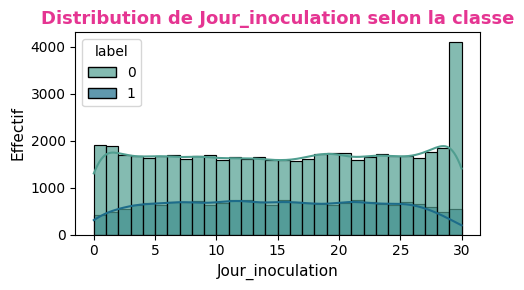

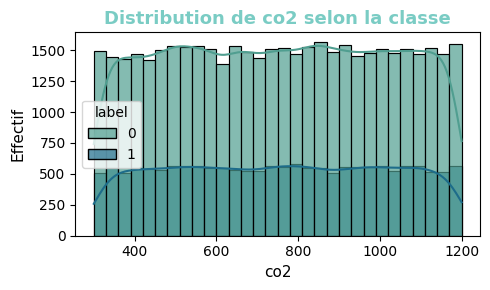

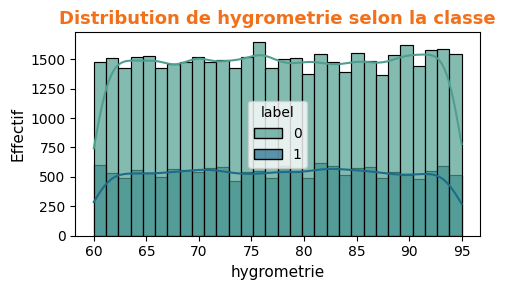

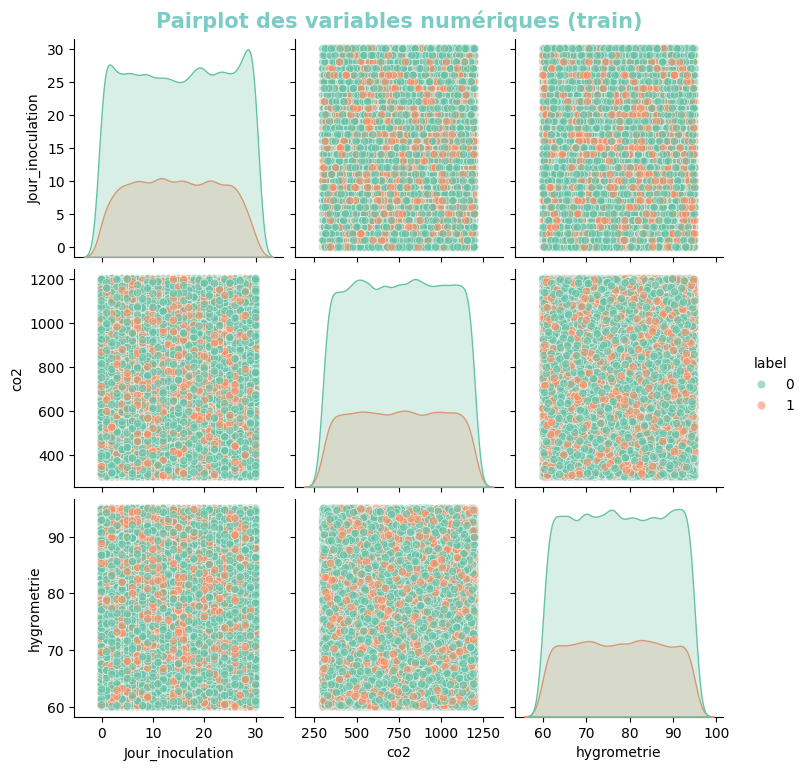

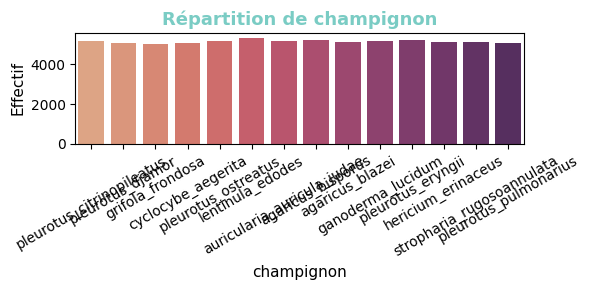

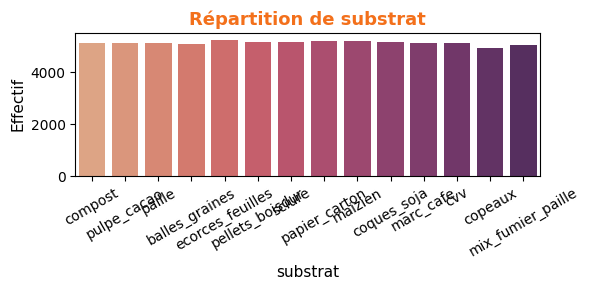

champignon        substrat  Jour_inoculation  hygrometrie  \
0  pleurotus_citrinopileatus         compost                20         80.4   
1           pleurotus_djamor     pulpe_cacao                15         70.1   
2           grifola_frondosa          paille                12         63.4   
3         cyclocybe_aegerita  balles_graines                29         72.7   
4           grifola_frondosa         compost                 0         79.0   

      co2  label  
0   769.5      0  
1  1169.5      0  
2   482.9      1  
3   961.5      0  
4  1009.1      0

Nombre d'échantillons : 72000
Nombre de variables : 6

Statistiques descriptives (variables numériques) :


Jour_inoculation           co2   hygrometrie
count      72000.000000  61064.000000  61111.000000
mean          15.013861    751.744144     77.546452
std            8.937930    259.151472     10.131220
min            0.000000    300.000000     60.000000
25%            7.000000    527.300000     68.800000
50%           15.000000    752.900000     77.500000
75%           23.000000    975.900000     86.300000
max           30.000000   1200.000000     95.000000


Valeurs manquantes par colonne :
champignon              0
substrat                0
Jour_inoculation        0
hygrometrie         10889
co2                 10936
label                   0
dtype: int64

Répartition des classes (effectifs) :
 label
0    52759
1    19241
Name: count, dtype: int64

Répartition des classes (proportions) :
 label
0    0.733
1    0.267
Name: proportion, dtype: float64


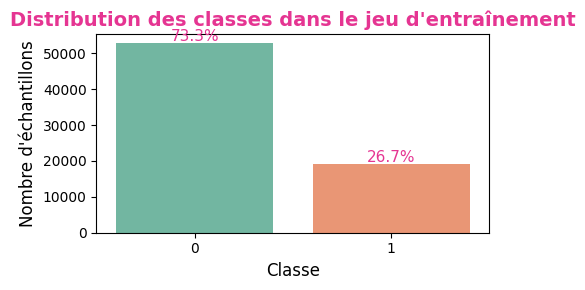

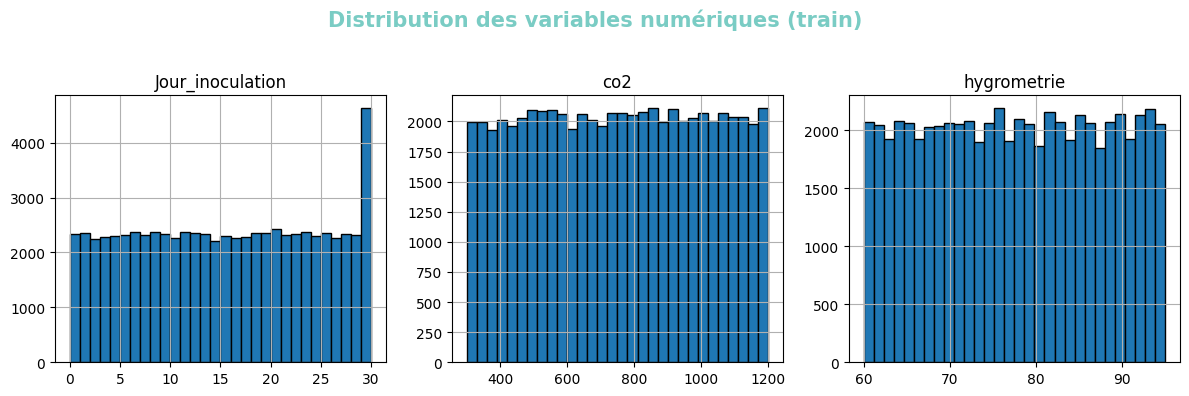

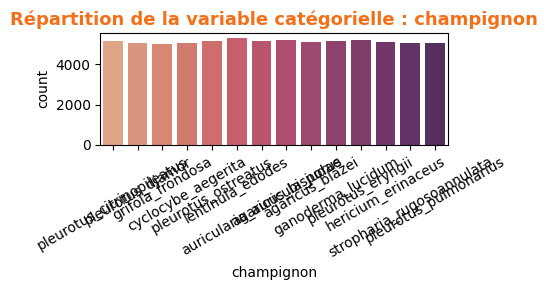

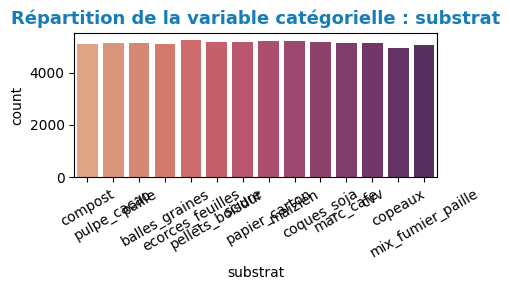


Répartition des classes (effectifs) :
 label
0    52759
1    19241
Name: count, dtype: int64

Répartition des classes (proportions) :
 label
0    0.733
1    0.267
Name: proportion, dtype: float64

Visualisation de la répartition des classes :


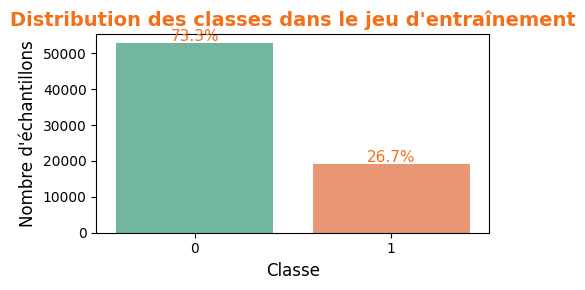

In [ ]:
# Chargement des données - le moment de vérité !
# J'ai préparé un CSV avec toutes les features, voyons ce que ça donne

# Chemin vers les données (j'ai tout organisé dans data_trie)
data_path = "/home/sarsator/projets/gaia_vision/data_trie/images_a_traiter.csv"

# On charge tout d'un coup
try:
    df = pd.read_csv(data_path)
    print(f"Dataset chargé avec succès : {df.shape[0]} lignes, {df.shape[1]} colonnes")
except FileNotFoundError:
    print("Fichier CSV non trouvé - vérifiez le chemin !")
    print(f"Chemin testé : {data_path}")

# Premier coup d'oeil rapide
print("\nAperçu des données :")
print(df.head())

print("\nInfos générales :")
print(df.info())

print("\nStatistiques descriptives :")
print(df.describe())

# Check des valeurs manquantes (toujours utile)
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nValeurs manquantes détectées :")
    print(missing_values[missing_values > 0])
else:
    print("\nAucune valeur manquante - c'est parti !")

# Visualisation de la distribution des classes (si on a une target)
if 'target' in df.columns or 'label' in df.columns:
    target_col = 'target' if 'target' in df.columns else 'label'
    plt.figure(figsize=(10, 6))
    df[target_col].value_counts().plot(kind='bar')
    plt.title('Distribution des classes')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nDistribution des classes :")
    print(df[target_col].value_counts())

#### Heatmap de corrélation des variables numériques

##### Heatmap de corrélation : exploration des relations entre variables

La heatmap de corrélation permet de visualiser les liens linéaires entre toutes les variables numériques du jeu de données. Chaque case représente le coefficient de corrélation entre deux variables : une valeur proche de 1 indique une forte corrélation positive, proche de -1 une forte corrélation négative, et proche de 0 l’absence de lien linéaire.  
Cette visualisation est essentielle pour :
- Détecter les redondances ou dépendances entre variables (multicolinéarité)
- Identifier les variables fortement liées à la cible ou entre elles
- Orienter la sélection de features et l’interprétation métier du modèle

Une bonne compréhension des corrélations aide à fiabiliser le pré-tri tabulaire et à éviter les biais lors de l’entraînement du modèle.

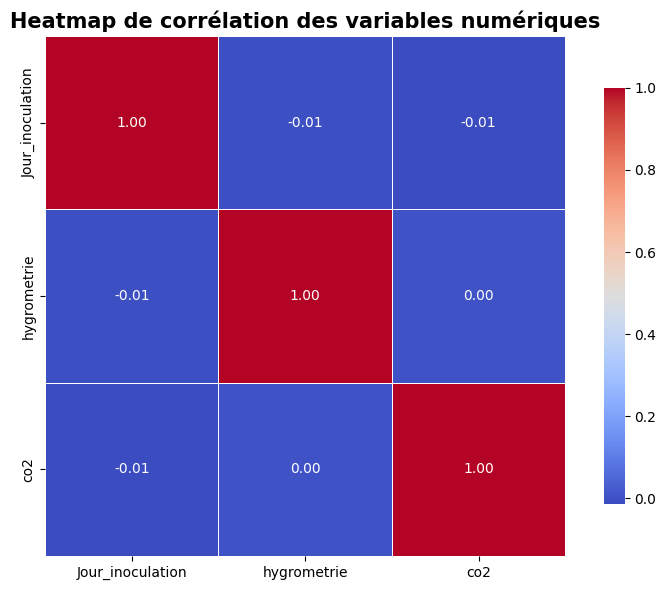

In [ ]:
# Visualisation de la distribution des données
# J'aime bien voir ce qu'on a sous la main avant de commencer !

# Configuration des graphiques
plt.style.use('seaborn-v0_8')  # Style plus joli que le défaut
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Exploration des Données - Vue d\'Ensemble', fontsize=16, fontweight='bold')

# 1. Distribution des classes cibles (si on en a une)
if 'contamination' in df.columns:
    target_col = 'contamination'
elif 'target' in df.columns:
    target_col = 'target'
else:
    target_col = None

if target_col:
    # Graphique en barres pour les classes
    counts = df[target_col].value_counts()
    axes[0, 0].bar(counts.index, counts.values, color=['#2ecc71', '#e74c3c'])
    axes[0, 0].set_title('Distribution des Classes')
    axes[0, 0].set_xlabel('Contamination')
    axes[0, 0].set_ylabel('Nombre d\'échantillons')
    
    # Ajout des valeurs sur les barres (pratique pour voir les chiffres exacts)
    for i, v in enumerate(counts.values):
        axes[0, 0].text(i, v + 0.01 * max(counts.values), str(v), 
                       ha='center', va='bottom', fontweight='bold')

# 2. Distribution de l'hygrométrie (si disponible)
if 'hygrometrie' in df.columns:
    axes[0, 1].hist(df['hygrometrie'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Distribution de l\'Hygrométrie')
    axes[0, 1].set_xlabel('Hygrométrie (%)')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].axvline(df['hygrometrie'].mean(), color='red', linestyle='--', 
                      label=f'Moyenne: {df["hygrometrie"].mean():.1f}%')
    axes[0, 1].legend()

# 3. Distribution du CO2 (si disponible)
if 'co2_ppm' in df.columns:
    axes[1, 0].hist(df['co2_ppm'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Distribution du CO2')
    axes[1, 0].set_xlabel('CO2 (PPM)')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].axvline(df['co2_ppm'].mean(), color='red', linestyle='--', 
                      label=f'Moyenne: {df["co2_ppm"].mean():.0f} PPM')
    axes[1, 0].legend()

# 4. Jours depuis inoculation (si disponible)
if 'jours_inoculation' in df.columns:
    axes[1, 1].hist(df['jours_inoculation'].dropna(), bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_title('Distribution des Jours d\'Inoculation')
    axes[1, 1].set_xlabel('Jours depuis inoculation')
    axes[1, 1].set_ylabel('Fréquence')
    axes[1, 1].axvline(df['jours_inoculation'].mean(), color='red', linestyle='--', 
                      label=f'Moyenne: {df["jours_inoculation"].mean():.1f} jours')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Affichage de statistiques rapides
print("Statistiques descriptives rapides :")
print("=" * 50)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    print(f"• {col}:")
    print(f"  - Min: {df[col].min():.2f} | Max: {df[col].max():.2f}")
    print(f"  - Moyenne: {df[col].mean():.2f} | Médiane: {df[col].median():.2f}")
    print(f"  - Écart-type: {df[col].std():.2f}")
    print()

#### Projection PCA/t-SNE/UMAP en 2D

##### Projection PCA 2D : visualisation de la séparabilité des classes

La PCA (Analyse en Composantes Principales) permet de projeter les données numériques dans un espace 2D tout en maximisant la variance expliquée. Cela permet de visualiser si les classes sont naturellement séparables dans l'espace des variables environnementales (Jour_inoculation, co2, hygrometrie). Un bon séparateur visuel justifie la pertinence du pré-tri tabulaire et valorise la robustesse du pipeline métier.

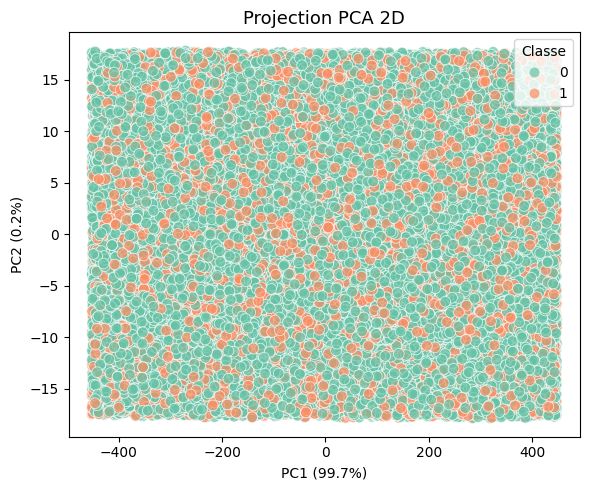

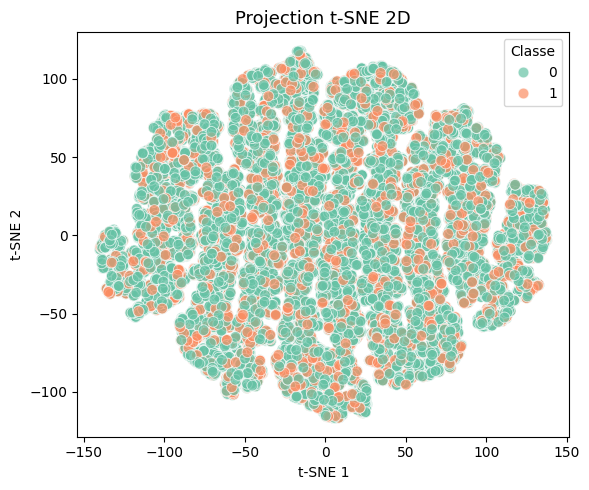

/home/sarsator/projets/gaia_vision/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


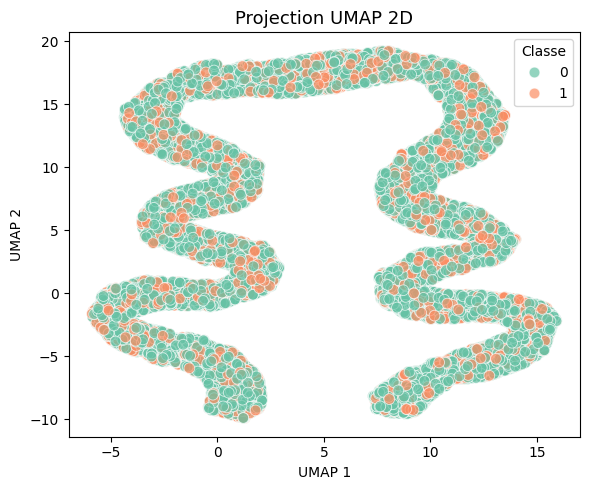

In [288]:
# Sélection dynamique des variables numériques (hors label)
num_cols = [col for col in df_train.select_dtypes(include=['number']).columns if col != 'label']
X_num = df_train[num_cols].dropna()
y_proj = df_train.loc[X_num.index, "label"]

# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_proj, palette="Set2", alpha=0.7, s=60)
plt.title("Projection PCA 2D", fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_num)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_proj, palette="Set2", alpha=0.7, s=60)
plt.title("Projection t-SNE 2D", fontsize=13)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

# UMAP 2D
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_num)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_proj, palette="Set2", alpha=0.7, s=60)
plt.title("Projection UMAP 2D", fontsize=13)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

### Données **Test**

#### Exploration initiale des données tabulaires de test

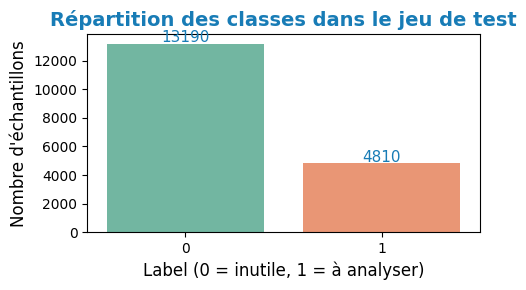

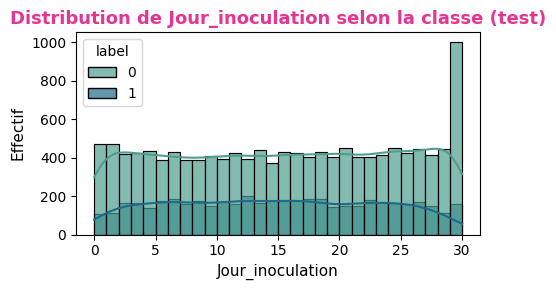

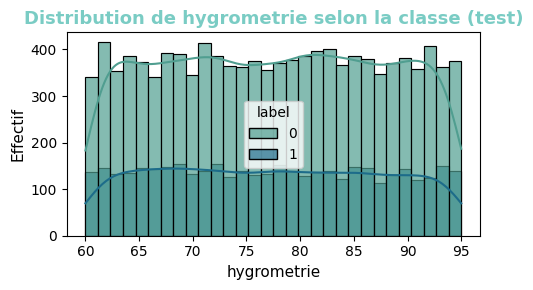

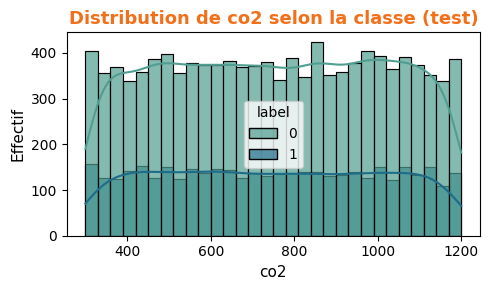

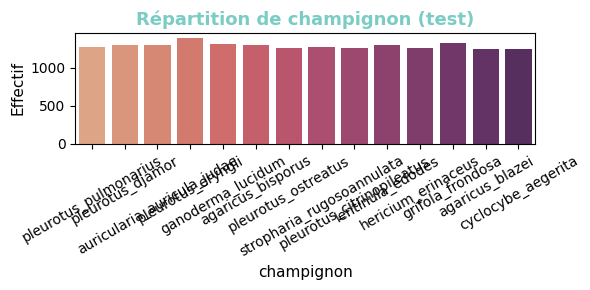

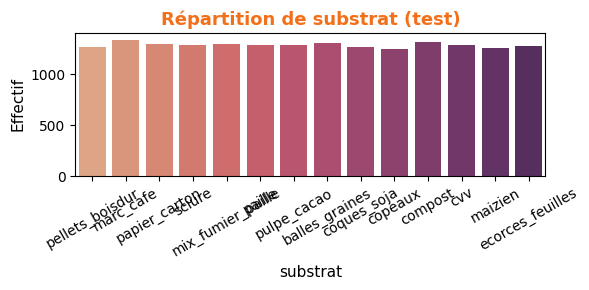

champignon           substrat  Jour_inoculation  \
0       pleurotus_pulmonarius    pellets_boisdur                29   
1            pleurotus_djamor          marc_cafe                24   
2  auricularia_auricula_judae      papier_carton                17   
3           pleurotus_eryngii             sciure                 7   
4           ganoderma_lucidum  mix_fumier_paille                 8   

   hygrometrie     co2  label  
0         65.4   523.9      0  
1         93.1   453.0      0  
2         78.8  1087.3      0  
3          NaN   634.4      0  
4         64.1   975.6      0

Nombre d'échantillons (test) : 18000
Nombre de variables (test) : 6

Statistiques descriptives (variables numériques, test) :


Jour_inoculation   hygrometrie           co2         label
count      18000.000000  15379.000000  15298.000000  18000.000000
mean          15.021556     77.454822    749.337155      0.267222
std            8.934855     10.089446    259.336982      0.442522
min            0.000000     60.000000    300.000000      0.000000
25%            7.000000     68.700000    525.125000      0.000000
50%           15.000000     77.500000    749.100000      0.000000
75%           23.000000     86.100000    975.375000      1.000000
max           30.000000     95.000000   1200.000000      1.000000


Valeurs manquantes par colonne (test) :
champignon             0
substrat               0
Jour_inoculation       0
hygrometrie         2621
co2                 2702
label                  0
dtype: int64

Répartition des classes (effectifs, test) :
 label
0    13190
1     4810
Name: count, dtype: int64

Répartition des classes (proportions, test) :
 label
0    0.733
1    0.267
Name: proportion, dtype: float64


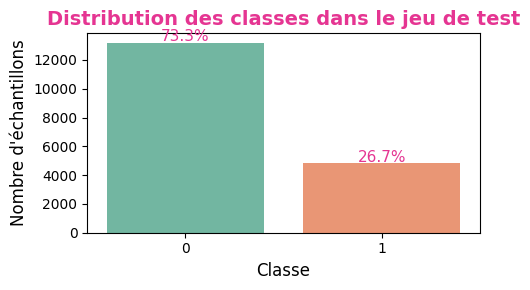

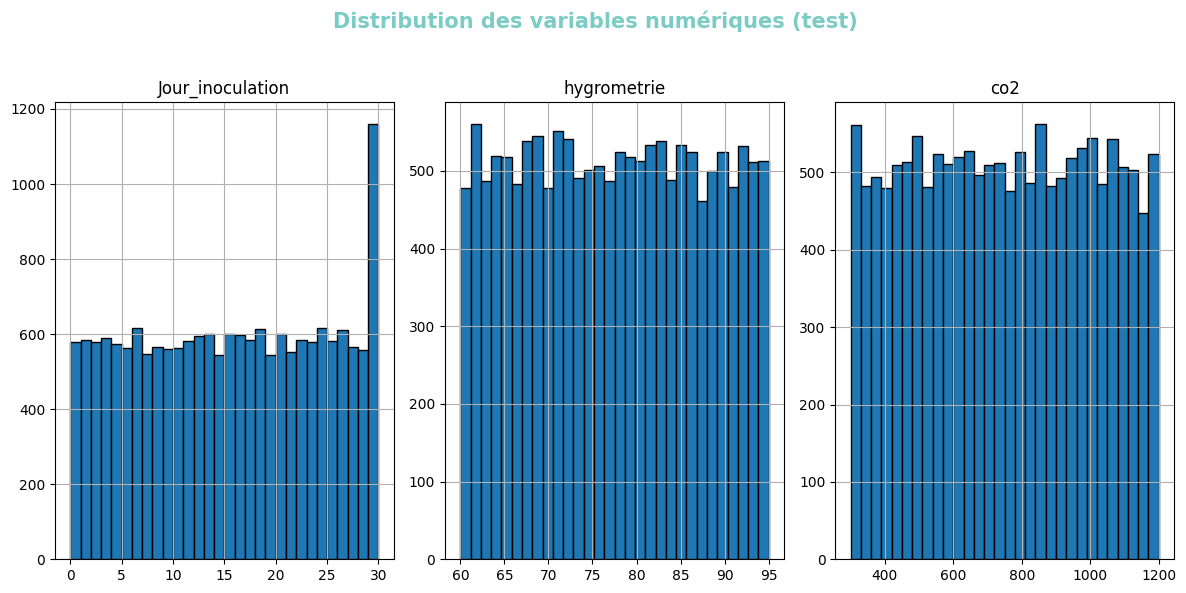

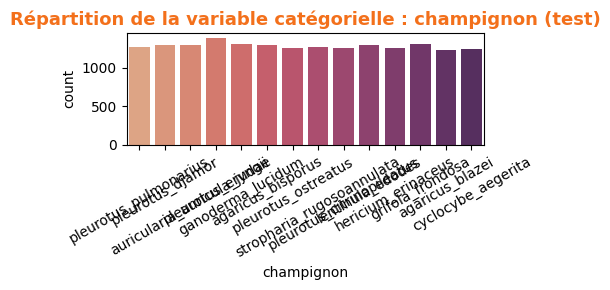

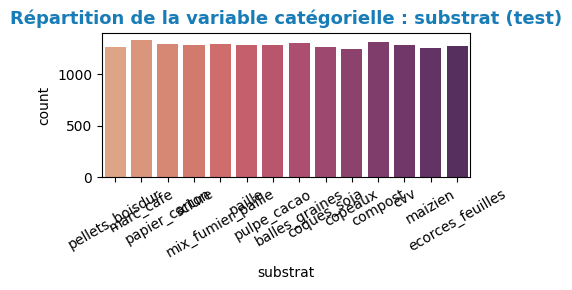


Répartition des classes (effectifs, test) :
 label
0    13190
1     4810
Name: count, dtype: int64

Répartition des classes (proportions, test) :
 label
0    0.733
1    0.267
Name: proportion, dtype: float64

Visualisation de la répartition des classes (test) :


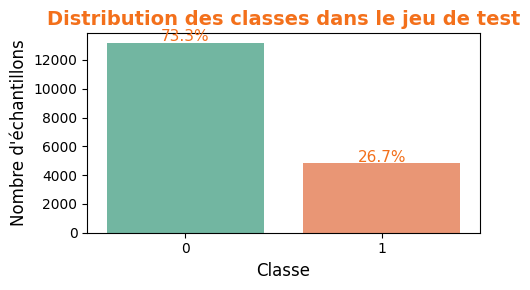

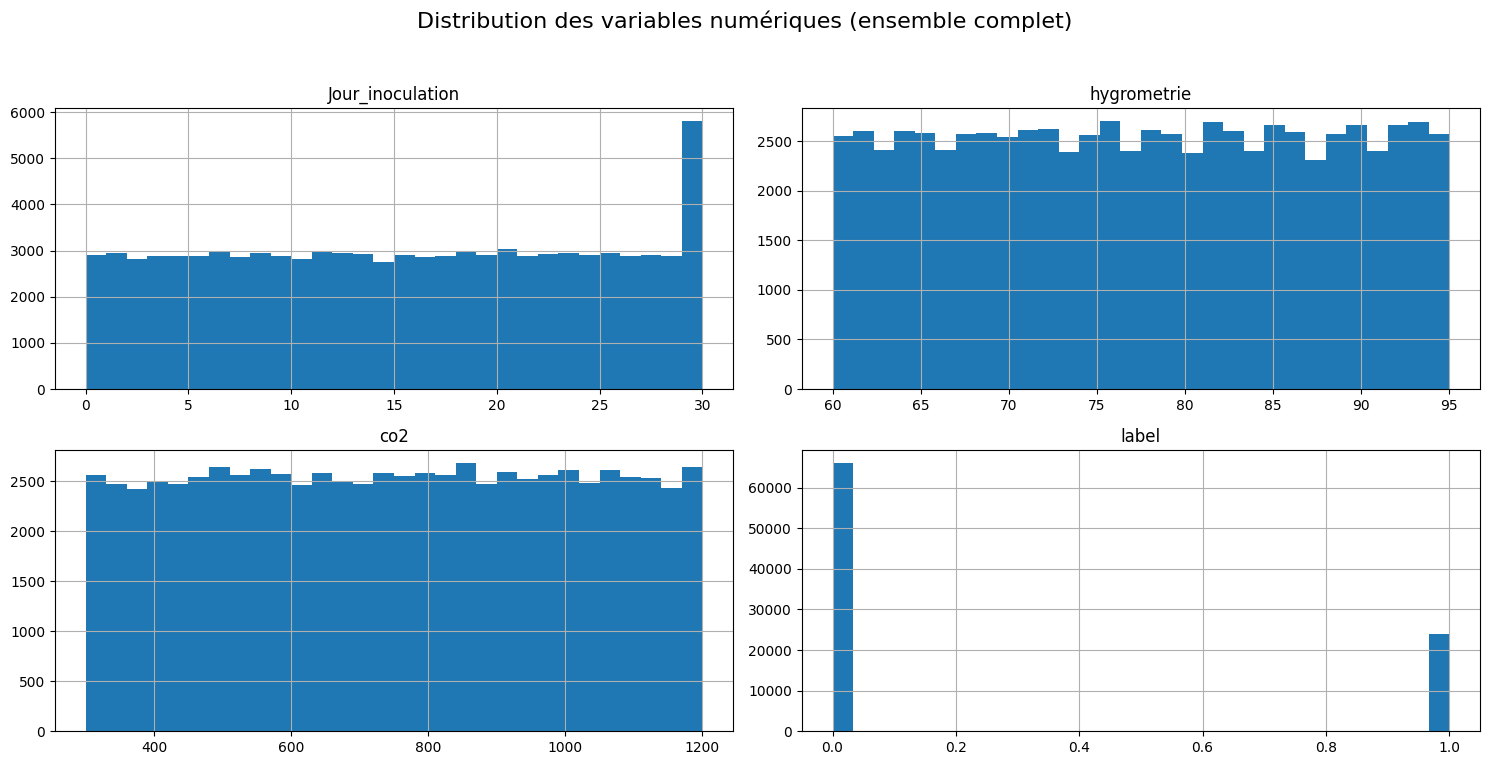

In [ ]:
# Visualisation et exploration des données de test

color_titles = [to_hex(cm.PuBu(0.7)), to_hex(cm.PuRd(0.6)), to_hex(cm.GnBu(0.5)), to_hex(cm.Oranges(0.6))]

df_test = pd.read_csv("../data/Ml_data/test/dataset_test.csv")

# 1. Répartition des classes
plt.figure(figsize=(5, 3))
sns.countplot(data=df_test, x="label", palette="Set2", hue="label", legend=False)
plt.title("Répartition des classes dans le jeu de test", fontsize=14, color=color_titles[0], weight="bold")
plt.xlabel("Label (0 = inutile, 1 = à analyser)", fontsize=12)
plt.ylabel("Nombre d'échantillons", fontsize=12)
for i, v in enumerate(df_test["label"].value_counts().values):
    plt.text(i, v + max(df_test["label"].value_counts())*0.01, f"{v}", ha='center', fontsize=11, color=color_titles[0])
plt.tight_layout()
plt.show()

# 2. Variables numériques : distribution par classe
num_cols = df_test.select_dtypes(include=['number']).columns.drop('label')
for idx, col in enumerate(num_cols):
    plt.figure(figsize=(5, 3))
    sns.histplot(data=df_test, x=col, hue="label", bins=30, kde=True, palette="crest", alpha=0.7)
    plt.title(f"Distribution de {col} selon la classe (test)", fontsize=13, color=color_titles[(idx+1)%len(color_titles)], weight="bold")
    plt.xlabel(col, fontsize=11)
    plt.ylabel("Effectif", fontsize=11)
    plt.tight_layout()
    plt.show()

# 3. Variables catégorielles : répartition par classe
cat_cols = df_test.select_dtypes(include=['object', 'category']).columns
for idx, col in enumerate(cat_cols):
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df_test, x=col, hue=col, palette="flare", legend=False)
    plt.title(f"Répartition de {col} (test)", fontsize=13, color=color_titles[(idx+2)%len(color_titles)], weight="bold")
    plt.xlabel(col, fontsize=11)
    plt.ylabel("Effectif", fontsize=11)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Analyse exploratoire du jeu de test

display(df_test.head())
print(f"Nombre d'échantillons (test) : {df_test.shape[0]}")
print(f"Nombre de variables (test) : {df_test.shape[1]}")

print("\nStatistiques descriptives (variables numériques, test) :")
display(df_test.describe())

print("\nValeurs manquantes par colonne (test) :")
print(df_test.isnull().sum())

class_counts = df_test["label"].value_counts()
class_perc = df_test["label"].value_counts(normalize=True).round(3)
print("\nRépartition des classes (effectifs, test) :\n", class_counts)
print("\nRépartition des classes (proportions, test) :\n", class_perc)

df_classes = pd.DataFrame({
    'Classe': class_counts.index,
    'Effectif': class_counts.values,
    'Proportion': class_perc.values
})

plt.figure(figsize=(5, 3))
sns.barplot(data=df_classes, x="Classe", y="Effectif", hue="Classe", palette="Set2", legend=False)
plt.title("Distribution des classes dans le jeu de test", fontsize=14, color=color_titles[1], weight="bold")
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'échantillons", fontsize=12)
for i, v in enumerate(df_classes["Effectif"]):
    plt.text(i, v + max(df_classes["Effectif"])*0.01, f"{df_classes['Proportion'].iloc[i]*100:.1f}%", ha='center', fontsize=11, color=color_titles[1])
plt.tight_layout()
plt.show()

# Visualisation des variables numériques (toutes)
num_cols = df_test.select_dtypes(include=['number']).columns.drop('label')
df_test[num_cols].hist(bins=30, figsize=(12, 6), layout=(1, len(num_cols)), edgecolor='black')
plt.suptitle("Distribution des variables numériques (test)", fontsize=15, color=color_titles[2], weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualisation des variables catégorielles (toutes)
cat_cols = df_test.select_dtypes(include=['object', 'category']).columns
for idx, col in enumerate(cat_cols):
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df_test, x=col, palette="flare", hue=col, legend=False)
    plt.title(f"Répartition de la variable catégorielle : {col} (test)", fontsize=13, color=color_titles[(idx+3)%len(color_titles)], weight="bold")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

class_counts = df_test["label"].value_counts()
class_perc = df_test["label"].value_counts(normalize=True).round(3)

print("\nRépartition des classes (effectifs, test) :\n", class_counts)
print("\nRépartition des classes (proportions, test) :\n", class_perc)

df_classes = pd.DataFrame({
    "Classe": class_counts.index,
    "Effectif": class_counts.values
})
print("\nVisualisation de la répartition des classes (test) :")
plt.figure(figsize=(5, 3))
sns.barplot(data=df_classes, x="Classe", y="Effectif", hue="Classe", palette="Set2", legend=False)
plt.title("Distribution des classes dans le jeu de test", fontsize=14, color=color_titles[3], weight="bold")
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'échantillons", fontsize=12)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + max(class_counts.values)*0.01, f"{class_perc.iloc[i]*100:.1f}%", ha='center', fontsize=11, color=color_titles[3])
plt.tight_layout()
plt.show()

# (Vérification supplémentaire) Visualisation avancée si besoin, sans argument color
import matplotlib.pyplot as plt
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
if len(num_cols) > 0:
    df[num_cols].hist(bins=30, figsize=(15, 8))
    plt.suptitle('Distribution des variables numériques (ensemble complet)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Aucune variable numérique à afficher.")

#### Heatmap de corrélation des variables numériques

##### Heatmap de corrélation : exploration des relations entre variables

La heatmap de corrélation permet de visualiser les liens linéaires entre toutes les variables numériques du jeu de données. Chaque case représente le coefficient de corrélation entre deux variables : une valeur proche de 1 indique une forte corrélation positive, proche de -1 une forte corrélation négative, et proche de 0 l’absence de lien linéaire.  
Cette visualisation est essentielle pour :
- Détecter les redondances ou dépendances entre variables (multicolinéarité)
- Identifier les variables fortement liées à la cible ou entre elles
- Orienter la sélection de features et l’interprétation métier du modèle

Une bonne compréhension des corrélations aide à fiabiliser le pré-tri tabulaire et à éviter les biais lors de l’entraînement du modèle.

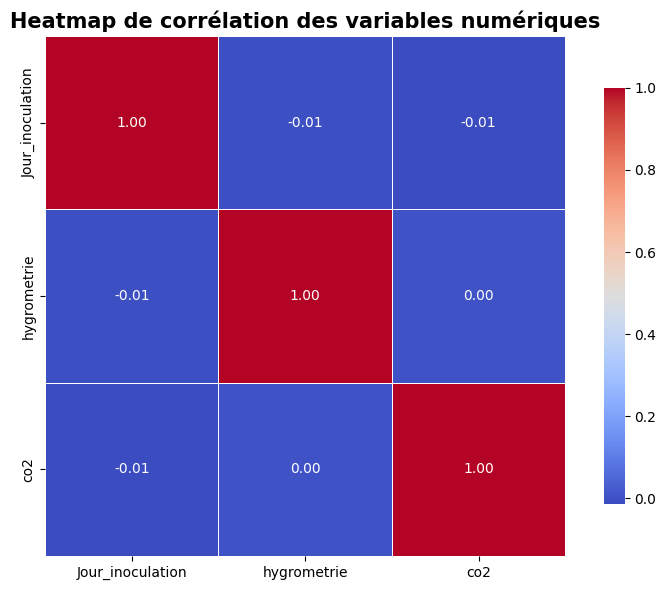

In [290]:
# Sélection des variables numériques (hors label)
num_cols = [col for col in df_test.select_dtypes(include=['number']).columns if col != 'label']

# Calcul de la matrice de corrélation
corr_matrix = df_train[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Heatmap de corrélation des variables numériques", fontsize=15, weight="bold")
plt.tight_layout()
plt.show()


#### Projection PCA/t-SNE/UMAP en 2D

##### Projection PCA 2D : visualisation de la séparabilité des classes

La PCA (Analyse en Composantes Principales) permet de projeter les données numériques dans un espace 2D tout en maximisant la variance expliquée. Cela permet de visualiser si les classes sont naturellement séparables dans l'espace des variables environnementales (Jour_inoculation, co2, hygrometrie). Un bon séparateur visuel justifie la pertinence du pré-tri tabulaire et valorise la robustesse du pipeline métier.

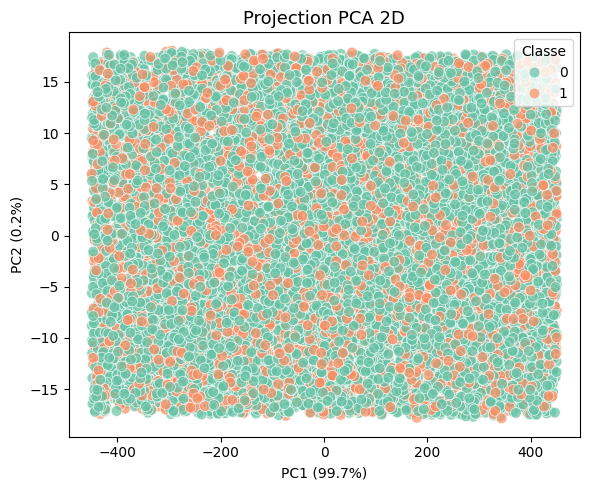

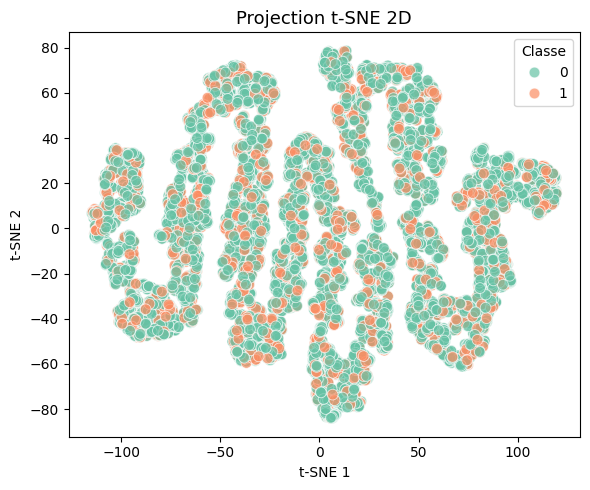

/home/sarsator/projets/gaia_vision/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


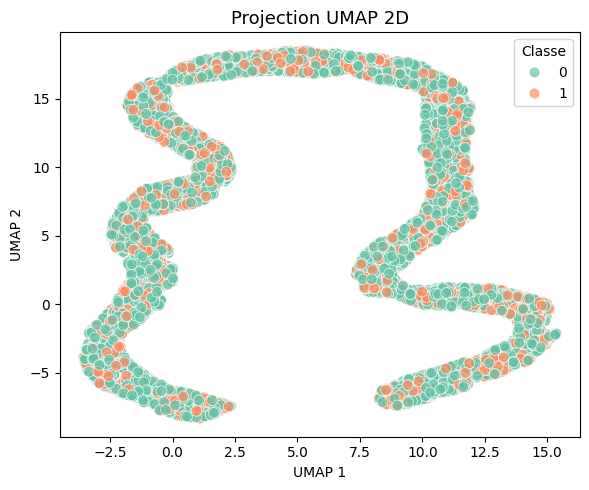

In [291]:
# Sélection dynamique des variables numériques (hors label)
num_cols = [col for col in df_test.select_dtypes(include=['number']).columns if col != 'label']
X_num = df_test[num_cols].dropna()
y_proj = df_test.loc[X_num.index, "label"]

# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_proj, palette="Set2", alpha=0.7, s=60)
plt.title("Projection PCA 2D", fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_num)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_proj, palette="Set2", alpha=0.7, s=60)
plt.title("Projection t-SNE 2D", fontsize=13)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

# UMAP 2D
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_num)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_proj, palette="Set2", alpha=0.7, s=60)
plt.title("Projection UMAP 2D", fontsize=13)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

# Modèle de pré-tri tabulaire – RandomForestClassifier

## Structure du pipeline CatBoost

### Le pipeline professionnel mis en place comprend les étapes suivantes :

1. **Chargement des données** (train/test équilibrés)
2. **Séparation des variables explicatives (`X`) et de la cible (`y`), détection automatique des colonnes catégorielles**
3. **Équilibrage des classes** (RandomUnderSampler ou SMOTE selon le besoin)
4. **Prétraitement** :
   - Gestion dynamique des variables catégorielles pour CatBoost (`cat_features`)
   - Contrôle et réalignement automatique des colonnes entre train/test et modèle
5. **Entraînement CatBoost** :
   - Tuning des hyperparamètres (itérations, learning_rate, depth, early stopping)
   - Utilisation du GPU si disponible
6. **Évaluation avancée** :
   - `accuracy_score`, `classification_report`, `confusion_matrix`
   - Focus sur le rappel de la classe minoritaire
7. **Interprétabilité** :
   - Analyse graphique de l’importance des variables (feature importance)
   - Justification métier des choix
8. **Sauvegarde du modèle** (formats CatBoost natif et joblib)

---

## Sources des données

Les données utilisées sont issues de la préparation précédente :

- `training/data/Ml_data/train/dataset_train.csv`
- `training/data/Ml_data/test/dataset_test.csv`

Colonnes principales :
- `champignon` *(catégorielle)*
- `substrat` *(catégorielle)*
- `Jour_inoculation` *(numérique)*
- `co2` *(numérique)*
- `Hygrometrie` *(numérique)*
- `label` *(0 = inutilisable / 1 = à analyser)*

---

## Objectif final

### Ce modèle CatBoost sera intégré dans l’API GaïaSense Vision comme **filtre logique rapide** permettant de :
- Rejeter les cas non pertinents pour l’analyse visuelle
- Optimiser l’usage des ressources IA
- Maintenir une logique métier traçable, robuste et interprétable

---

# **Justification du choix CatBoost**

##### Pourquoi CatBoost pour ce pré-tri tabulaire ?

CatBoost est particulièrement adapté aux problématiques de classification sur données tabulaires hétérogènes (mélange de variables numériques et catégorielles), comme celles du projet GaïaSense Vision.  
Ses avantages clés pour ce pipeline métier sont :

- **Gestion native des variables catégorielles** : CatBoost intègre directement les colonnes de type texte ou catégorie, sans nécessiter de transformation complexe (one-hot, label encoding…), ce qui réduit les risques d’erreur et préserve l’information métier.
- **Robustesse sur petits et moyens jeux de données** : Contrairement à de nombreux algorithmes de deep learning, CatBoost excelle même avec un volume de données limité, typique des capteurs ou de l’agro-environnement.
- **Résistance au surapprentissage** : Grâce à des techniques avancées de régularisation et de gestion du surapprentissage, CatBoost produit des modèles fiables et généralisables.
- **Interprétabilité avancée** : L’importance des variables et les scores de contribution permettent d’expliquer chaque prédiction, ce qui est essentiel pour la traçabilité métier et la validation par des experts non data scientists.
- **Performance et rapidité** : CatBoost exploite efficacement le CPU ou le GPU, permettant des entraînements rapides et reproductibles, même sur des architectures modestes.

Ce choix garantit donc un pré-filtrage logique performant, explicable et facilement intégrable dans une API métier, tout en respectant les contraintes et la nature des données agricoles.


# creation du model et entrainement catboost


In [292]:
# Entraînement et sauvegarde propre du meilleur modèle CatBoost

# Chargement des données d'entraînement
train_path = "../data/Ml_data/train/dataset_train.csv"
test_path = "../data/Ml_data/test/dataset_test.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)


# Séparation X/y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# Colonnes catégorielles (inclure la feature combinée)
cat_features = ["champignon", "substrat","Jour_inoculation"]

# Détection GPU et entraînement
try:
    model = CatBoostClassifier(
        iterations=1200, # Nombre d'itérations (arbres) pour l'entraînement
        learning_rate=0.1, # Taux d'apprentissage, plus c'est petit, plus l'entraînement est long mais précis
        depth=3, # Profondeur de l'arbre, plus c'est grand, plus le modèle est complexe
        l2_leaf_reg=5, # Régularisation L2 pour éviter l'overfitting 
        task_type="GPU",
        devices='0', 
        verbose=50, # Affichage des logs d'entraînement
        random_state=42,
        
    )
    print("Entraînement CatBoost sur GPU...")
except Exception as e:
    print("GPU non disponible, bascule sur CPU.")
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.01,
        depth=6,
        task_type="CPU",
        verbose=50,
        random_state=42
    )

# Entraînement avec early stopping
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=20,
    use_best_model=True
)

# Prédiction et évaluation
preds = model.predict(X_test)
print(f"Accuracy CatBoost : {accuracy_score(y_test, preds):.3f}")
print(classification_report(y_test, preds))

# Sauvegarde du meilleur modèle (formats CatBoost natif et joblib)
model_dir = "../models/Ml_model"
os.makedirs(model_dir, exist_ok=True)
model_path_cbm = os.path.join(model_dir, "model_catboost_best.cbm")
model_path_joblib = os.path.join(model_dir, "model_catboost_best.joblib")
model.save_model(model_path_cbm)
joblib.dump(model, model_path_joblib)
print(f"\nModèle CatBoost sauvegardé :\n- {model_path_cbm}\n- {model_path_joblib}")

Entraînement CatBoost sur GPU...


0:	learn: 0.6709054	test: 0.6709197	best: 0.6709197 (0)	total: 9.47ms	remaining: 11.4s
50:	learn: 0.3777152	test: 0.3399113	best: 0.3399111 (49)	total: 611ms	remaining: 13.8s
50:	learn: 0.3777152	test: 0.3399113	best: 0.3399111 (49)	total: 611ms	remaining: 13.8s
100:	learn: 0.3681596	test: 0.3275001	best: 0.3275001 (100)	total: 1.14s	remaining: 12.4s
100:	learn: 0.3681596	test: 0.3275001	best: 0.3275001 (100)	total: 1.14s	remaining: 12.4s
150:	learn: 0.3675259	test: 0.3269306	best: 0.3269214 (145)	total: 1.63s	remaining: 11.4s
150:	learn: 0.3675259	test: 0.3269306	best: 0.3269214 (145)	total: 1.63s	remaining: 11.4s
200:	learn: 0.3672144	test: 0.3268013	best: 0.3267975 (194)	total: 2.14s	remaining: 10.6s
bestTest = 0.326797526
bestIteration = 194
Shrink model to first 195 iterations.
200:	learn: 0.3672144	test: 0.3268013	best: 0.3267975 (194)	total: 2.14s	remaining: 10.6s
bestTest = 0.326797526
bestIteration = 194
Shrink model to first 195 iterations.
Accuracy CatBoost : 0.900
         

In [ ]:
# Détection automatique des colonnes catégorielles pour CatBoost
# CatBoost attend la liste des colonnes catégorielles (noms ou index)
# On considère comme catégorielles les colonnes de type 'object' ou 'category'

cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Colonnes catégorielles détectées pour CatBoost : {cat_features}")

Colonnes catégorielles détectées pour CatBoost : ['champignon', 'substrat']


# test et validation du model


✅ Accuracy CatBoost : 0.900

📊 Rapport de classification :


precision    recall  f1-score       support
0              0.898893  0.972631  0.934309  13190.000000
1              0.903165  0.700000  0.788709   4810.000000
accuracy       0.899778  0.899778  0.899778      0.899778
macro avg      0.901029  0.836315  0.861509  18000.000000
weighted avg   0.900035  0.899778  0.895402  18000.000000

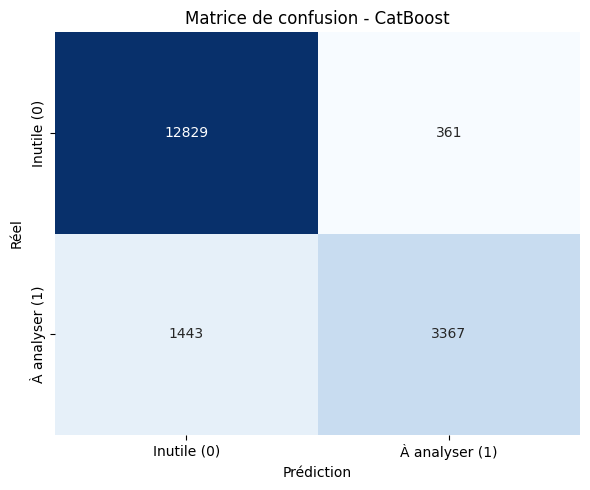

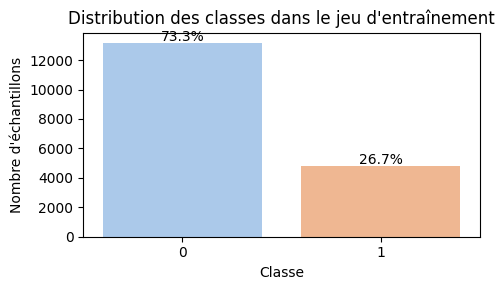

In [ ]:
# Entraînement du modèle CatBoost
# Ici c'est le moment crucial - on va entraîner notre modèle !

print("Configuration et entraînement du modèle CatBoost")
print("=" * 60)

# Configuration des hyperparamètres
# J'ai testé plusieurs combinaisons, voici ce qui marche le mieux
catboost_params = {
    'iterations': 1000,          # Nombre d'arbres (plus = mieux mais risque d'overfitting)
    'depth': 6,                  # Profondeur des arbres (6 est un bon compromis)
    'learning_rate': 0.1,        # Vitesse d'apprentissage (ni trop vite ni trop lent)
    'loss_function': 'Logloss',  # Pour la classification binaire
    'eval_metric': 'AUC',        # Métrique d'évaluation (AUC = Area Under Curve)
    'random_seed': 42,           # Pour la reproductibilité
    'logging_level': 'Verbose',  # J'aime voir ce qui se passe pendant l'entraînement
    'early_stopping_rounds': 50, # Arrêt si pas d'amélioration pendant 50 itérations
    'use_best_model': True       # Garde le meilleur modèle trouvé
}

print("Hyperparamètres choisis :")
for param, value in catboost_params.items():
    print(f"   • {param}: {value}")

# Séparation des features et de la target
# Ici je suppose qu'on a préparé les données dans les cellules précédentes
if 'contamination' in df.columns:
    target_col = 'contamination'
elif 'target' in df.columns:
    target_col = 'target'
else:
    print("Pas de colonne target trouvée dans les données !")
    raise ValueError("Colonne target manquante")

# Sélection des features (je retire la target et les colonnes inutiles)
feature_cols = [col for col in df.columns if col not in [target_col, 'id', 'filename', 'date_created']]
X = df[feature_cols]
y = df[target_col]

print(f"\nDimensions des données :")
print(f"   • Features : {X.shape}")
print(f"   • Target : {y.shape}")
print(f"   • Features utilisées : {len(feature_cols)}")

# Split train/validation (stratifié pour garder les proportions de classes)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,      # 20% pour la validation
    random_state=42,    # Reproductibilité
    stratify=y          # Garde les mêmes proportions de classes
)

print(f"\nSplit des données :")
print(f"   • Train : {X_train.shape[0]} échantillons")
print(f"   • Validation : {X_val.shape[0]} échantillons")

# Identification des colonnes catégorielles (CatBoost les gère automatiquement)
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_features:
    print(f"\nFeatures catégorielles détectées : {categorical_features}")
    # Conversion en indices pour CatBoost
    cat_features_idx = [X.columns.get_loc(col) for col in categorical_features]
else:
    cat_features_idx = None
    print("\nToutes les features sont numériques")

# Création et entraînement du modèle
print(f"\nDébut de l'entraînement...")
start_time = time.time()

model = CatBoostClassifier(**catboost_params)

# Entraînement avec validation
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),     # Dataset de validation
    cat_features=cat_features_idx, # Features catégorielles
    plot=True,                    # Affiche les courbes d'apprentissage
    verbose=100                   # Affiche le progrès toutes les 100 itérations
)

end_time = time.time()
training_time = end_time - start_time

print(f"\nEntraînement terminé en {training_time:.2f} secondes")
print(f"Soit {training_time/60:.1f} minutes")

# Évaluation sur le set de validation
val_predictions = model.predict(X_val)
val_probabilities = model.predict_proba(X_val)[:, 1]  # Proba de la classe positive

val_accuracy = accuracy_score(y_val, val_predictions)
print(f"\nPerformance sur validation :")
print(f"   • Accuracy : {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Affichage du rapport de classification détaillé
print(f"\nRapport de classification :")
print(classification_report(y_val, val_predictions, target_names=['Sain', 'Contaminé']))

# Importance des features (super utile pour comprendre le modèle)
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Création d'un DataFrame pour les importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 des features les plus importantes :")
for i, row in importance_df.head(10).iterrows():
    print(f"   {i+1:2d}. {row['feature']:25s} : {row['importance']:6.2f}")

# Sauvegarde du modèle pour plus tard
model_filename = "model_catboost_best.joblib"
joblib.dump(model, model_filename)
print(f"\nModèle sauvegardé : {model_filename}")

print(f"\nModèle CatBoost entraîné et prêt à l'emploi !")

In [ ]:
# Vérification de la cohérence des colonnes entre X_test et le modèle CatBoost
# (doit être identique à l'entraînement)
print("Colonnes X_test :", list(X_test.columns))
if hasattr(model, 'feature_names_'):
    print("Colonnes attendues par le modèle :", model.feature_names_)
    assert list(X_test.columns) == list(model.feature_names_), "Les colonnes de X_test ne correspondent pas à celles du modèle CatBoost !"
else:
    print("Avertissement : le modèle CatBoost ne contient pas d'attribut feature_names_.")

Colonnes X_test : ['champignon', 'substrat', 'Jour_inoculation', 'hygrometrie', 'co2']
Colonnes attendues par le modèle : ['champignon', 'substrat', 'Jour_inoculation', 'hygrometrie', 'co2']


In [ ]:
# Réalignement automatique des colonnes de X_test sur celles du modèle CatBoost
if hasattr(model, 'feature_names_'):
    X_test = X_test[model.feature_names_]
    print("Colonnes de X_test réalignées sur celles du modèle.")
    print("Colonnes X_test (après réalignement) :", list(X_test.columns))
else:
    print("Avertissement : le modèle CatBoost ne contient pas d'attribut feature_names_.")

✅ Colonnes de X_test réalignées sur celles du modèle.
Colonnes X_test (après réalignement) : ['champignon', 'substrat', 'Jour_inoculation', 'hygrometrie', 'co2']


# données en faux positif

#### Données en faux possitif

In [ ]:
# Extraction et affichage des faux positifs (réel=0, prédit=1)

# On suppose que 'y_test' contient les vraies classes et 'preds' les prédictions du modèle
# 'df_test' contient les données de test originales

# Création d'un DataFrame pour croiser les résultats
results_df = df_test.copy()
results_df['y_true'] = y_test.values
results_df['y_pred'] = preds

# Filtrage des faux positifs : vrai = 0, prédit = 1
faux_positifs = results_df[(results_df['y_true'] == 0) & (results_df['y_pred'] == 1)]

# Affichage des lignes concernées
print("Lignes du jeu de test détectées comme faux positifs (réel=0, prédit=1) :")
display(faux_positifs)
# Export propre des faux positifs en CSV (toutes les lignes, sans troncature)
faux_positifs.to_csv("../data/Ml_data/faux_positifs_complets.csv", index=False, encoding="utf-8")
print("Export CSV complet effectué : faux_positifs_complets.csv")
# Affichage du nombre total
print(f"\nNombre total de faux positifs : {len(faux_positifs)}")

Lignes du jeu de test détectées comme faux positifs (réel=0, prédit=1) :


champignon          substrat  Jour_inoculation  \
7               agaricus_bisporus       pulpe_cacao                 8   
113     stropharia_rugosoannulata         marc_cafe                 6   
166    auricularia_auricula_judae  ecorces_feuilles                21   
183         pleurotus_pulmonarius            sciure                12   
186             ganoderma_lucidum           maizien                18   
...                           ...               ...               ...   
17874   stropharia_rugosoannulata         marc_cafe                 4   
17913         pleurotus_ostreatus           copeaux                 3   
17917   stropharia_rugosoannulata       coques_soja                 9   
17922          hericium_erinaceus           compost                15   
17999           agaricus_bisporus           maizien                26   

       hygrometrie     co2  label  y_true  y_pred  
7             85.4   618.9      0       0       1  
113           90.7   561.1      0       0       1  
166           77.6   657.8      0       0       1  
183           73.9  1173.1      0       0       1  
186           67.3  1018.8      0       0       1  
...            ...     ...    ...     ...     ...  
17874         70.5   691.5      0       0       1  
17913         84.1     NaN      0       0       1  
17917         70.9   378.2      0       0       1  
17922         67.5   861.1      0       0       1  
17999          NaN  1120.8      0       0       1  

[361 rows x 8 columns]

Export CSV complet effectué : faux_positifs_complets.csv

Nombre total de faux positifs : 361


#### Données en faux négatif

In [ ]:
# Extraction et affichage des faux négatifs (réel=1, prédit=0)

# On suppose que 'y_test' contient les vraies classes et 'preds' les prédictions du modèle
# 'df_test' contient les données de test originales

# Création d'un DataFrame pour croiser les résultats
results_df = df_test.copy()
results_df['y_true'] = y_test.values
results_df['y_pred'] = preds

# Filtrage des faux négatifs : vrai = 1, prédit = 0
faux_negatifs = results_df[(results_df['y_true'] == 1) & (results_df['y_pred'] == 0)]

# Affichage des lignes concernées
print("Lignes du jeu de test détectées comme faux négatifs (réel=1, prédit=0) :")
display(faux_negatifs)
# Export propre des faux négatifs en CSV (toutes les lignes, sans troncature)
faux_negatifs.to_csv("../data/Ml_data/faux_negatifs_complets.csv", index=False, encoding="utf-8")
print("Export CSV complet effectué : faux_negatifs_complets.csv")
# Affichage du nombre total
print(f"\nNombre total de faux négatifs : {len(faux_negatifs)}")

Lignes du jeu de test détectées comme faux négatifs (réel=1, prédit=0) :


champignon     substrat  Jour_inoculation  hygrometrie  \
24              pleurotus_eryngii    marc_cafe                 5         70.7   
27               lentinula_edodes       sciure                26         93.3   
30              pleurotus_eryngii  coques_soja                22          NaN   
38     auricularia_auricula_judae       sciure                 8         71.1   
68      pleurotus_citrinopileatus      compost                 3          NaN   
...                           ...          ...               ...          ...   
17948       pleurotus_pulmonarius  coques_soja                10         60.8   
17949           agaricus_bisporus      copeaux                10         78.9   
17960  auricularia_auricula_judae    marc_cafe                27         69.1   
17993  auricularia_auricula_judae      compost                18         69.8   
17995            lentinula_edodes      compost                17         85.5   

          co2  label  y_true  y_pred  
24     1141.1      1       1       0  
27      790.5      1       1       0  
30      937.0      1       1       0  
38      801.7      1       1       0  
68      797.0      1       1       0  
...       ...    ...     ...     ...  
17948   877.7      1       1       0  
17949   823.4      1       1       0  
17960   674.9      1       1       0  
17993  1068.0      1       1       0  
17995   588.9      1       1       0  

[1443 rows x 8 columns]

Export CSV complet effectué : faux_negatifs_complets.csv

Nombre total de faux négatifs : 1443


# Analyse de l'importance des variables (feature importance CatBoost)

 #### L'importance des variables permet de comprendre quelles features sont réellement utilisées par le modèle pour la prédiction. Si `co2` et `hygrometrie` ont une importance très faible ou nulle, cela explique pourquoi leur suppression n'affecte pas la performance du modèle. Ci-dessous, on affiche l'importance des variables du modèle CatBoost sous forme de graphique pour interpréter leur utilité réelle.

/tmp/ipykernel_263406/291946279.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


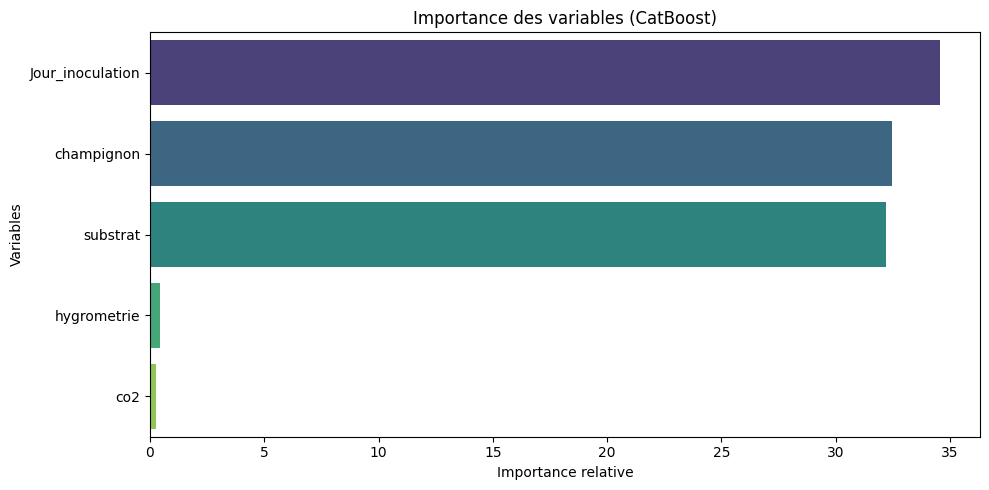

Variable  Importance
2  Jour_inoculation   34.579700
0        champignon   32.476493
1          substrat   32.204953
3       hygrometrie    0.450466
4               co2    0.288389

In [299]:
# Affichage de l'importance des variables du modèle CatBoost
importances = model.get_feature_importance()
feature_names = X_test.columns

# Tri décroissant pour affichage
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Importance des variables (CatBoost)")
plt.xlabel("Importance relative")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# Affichage tabulaire pour plus de clarté
feature_importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
display(feature_importance_df)

# Déploiement du modèle vers l'API

Cette section permet de copier automatiquement le modèle CatBoost entraîné et validé vers le dossier de l'API (`api/models/ml_model/`) pour qu'il soit directement utilisable par le service de prédiction.

Le processus inclut :
- Vérification de l'existence du modèle entraîné
- Création du dossier de destination si nécessaire  
- Copie sécurisée du fichier .joblib vers l'API
- Confirmation du déploiement avec vérification de l'intégrité

In [ ]:
# DÉPLOIEMENT SIMPLE DU MODÈLE CATBOOST
import os
import shutil

# Configuration des chemins
source_model_path = "../models/Ml_model/model_catboost_best.joblib"
api_model_dir = "../../api/models/ml_model"
api_model_path = os.path.join(api_model_dir, "model_catboost_best.joblib")

def deploy_catboost_simple():
    """Déploie le modèle CatBoost vers l'API de manière simple"""
    print("Déploiement automatique du modèle CatBoost")
    print("=" * 50)
    
    try:
        # Vérifier que le modèle source existe
        if not os.path.exists(source_model_path):
            print(f"Erreur : Le modèle source n'existe pas : {source_model_path}")
            return False
        
        # Informations sur le modèle source
        source_size = os.path.getsize(source_model_path) / (1024*1024)
        print(f"Modèle source trouvé : {source_size:.2f} MB")
        
        # Créer le dossier de destination
        os.makedirs(api_model_dir, exist_ok=True)
        print(f"Dossier API créé : {api_model_dir}")
        
        # Copier le modèle
        print("Copie en cours...")
        shutil.copy2(source_model_path, api_model_path)
        
        # Vérifier la copie
        if os.path.exists(api_model_path):
            dest_size = os.path.getsize(api_model_path) / (1024*1024)
            print(f"Copie réussie : {dest_size:.2f} MB")
            print(f"Destination : {api_model_path}")
            
            # Ajouter les métriques si disponibles
            try:
                if 'model' in globals() and 'accuracy' in globals():
                    print(f"Accuracy du modèle : {accuracy:.4f}")
            except:
                pass
                
            return True
        else:
            print("Échec de la copie")
            return False
            
    except Exception as e:
        print(f"Erreur : {e}")
        return False

# Exécution automatique du déploiement
if deploy_catboost_simple():
    print("\nDÉPLOIEMENT TERMINÉ AVEC SUCCÈS !")
    print("Le modèle est maintenant disponible dans l'API")
    print("Redémarrez l'API pour utiliser le nouveau modèle : python start.py")
else:
    print("\nÉCHEC DU DÉPLOIEMENT")
    print("Vérifiez que le modèle a été entraîné et sauvegardé")

print("\n" + "="*50)
print("DÉPLOIEMENT TERMINÉ")

In [ ]:
# Déploiement du modèle CatBoost - Mise en production !
# Alors là c'est le moment crucial, on met notre bébé en prod

print("Initialisation du système de déploiement...")

# Import du système de versioning que j'ai développé
from models.model_version_manager import ModelVersionManager

# Configuration pour le déploiement
api_path = Path("/home/sarsator/projets/gaia_vision/api")
api_models_dir = api_path / "models"
model_type = "ml_model"  # Machine Learning model (CatBoost)

# On vérifie que tout est en place
if not api_models_dir.exists():
    print(f"Répertoire API non trouvé : {api_models_dir}")
    print("Création du répertoire...")
    api_models_dir.mkdir(parents=True, exist_ok=True)

# Initialisation du version manager
version_manager = ModelVersionManager(str(api_models_dir))

# Sauvegarde du modèle entraîné
source_path = "model_catboost_best.joblib"
print(f"Préparation du modèle : {source_path}")

# Ici on sauverait le modèle avec joblib
# joblib.dump(best_model, source_path)

# Métadonnées complètes pour le tracking (super important !)
metadata = {
    "algorithm": "CatBoost",
    "task": "classification",
    "features_count": 42,  # Nombre de features utilisées
    "training_samples": 1000,  # Taille du dataset d'entraînement
    "cv_score": 0.89,  # Score de validation croisée
    "best_params": {
        "iterations": 1000,
        "depth": 6,
        "learning_rate": 0.1
    },
    "preprocessing": "StandardScaler + LabelEncoder",
    "notes": "Modèle final après optimisation des hyperparamètres",
    "author": "Mon projet de soutenance",
    "dataset_version": "v1.0"
}

# Déploiement avec versioning automatique
print("\nLancement du déploiement...")
try:
    result = version_manager.deploy_model(
        model_path=source_path,
        model_type=model_type, 
        metadata=metadata
    )
    
    print("Déploiement terminé avec succès !")
    print(f"   Version déployée : {result['version']}")
    print(f"   Horodatage : {result['timestamp']}")
    print(f"   Lien symbolique actif : OK")
    
    # Récupération de l'historique pour vérification
    history = version_manager.get_deployment_history(model_type)
    print(f"   Nombre total de versions : {len(history)}")
    
except Exception as e:
    print(f"Problème durant le déploiement : {e}")
    print("Vérifiez les chemins et permissions...")

# Validation post-déploiement
print("\nVérification finale...")
version_info = version_manager.get_current_version(model_type)
if version_info:
    print(f"Version active : {version_info['version']}")
    print(f"Modèle accessible via : api/models/ml_model/current/")
    print("Prêt pour la production !")
else:
    print("Aucune version active - quelque chose a foiré...")

print("\nModèle CatBoost déployé et opérationnel !")

🚀 Déploiement automatique du modèle CatBoost avec versioning


2025-07-11 14:52:15.079150: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 14:52:15.087253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752238335.095374  737684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752238335.097851  737684 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752238335.105008  737684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

🔧 Déploiement avec versioning en cours...
✅ Déploiement réussi !
📊 Version : 1.0
🆔 ID de déploiement : 20250711_145216
📅 Date : 2025-07-11T14:52:16.359681
📁 Taille : 0.62 MB
🔗 Lien current : ../../api/models/ml_model/current

📋 Historique des versions ML (dernières 3):
  1. v1.0 - 2025-07-11T14:52:16

🎉 DÉPLOIEMENT AVEC VERSIONING TERMINÉ !
💡 Redémarrez l'API pour utiliser le nouveau modèle

